Download the support file for IS computation.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
"""
from google.colab import auth
auth.authenticate_user()
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')
import io
import os
from googleapiclient.http import MediaIoBaseDownload
def download_file(fn, file_id):
    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
        # _ is a placeholder for a progress object that we ignore.
        # (Our file is small, so we skip reporting progress.)
        _, done = downloader.next_chunk()
    downloaded.seek(0)
    folder = fn.split('/')
    if len(folder) > 1:
        os.makedirs(folder[0], exist_ok=True)
    with open(fn, 'wb') as f:
        f.write(downloaded.read())
id_to_fn = {
'1z-3wIa4MzQp2fHHn2_1v1ZuI8sYKXrTw': 'inception_score.py',
'1ijo3v_Y-XrV8ytpWRey9PvHy_NV9cTBE': 'test_case_VAE.zip',
'1FZyHINMFqELoTjWUHSwM3krMF1bH3ROV': 'test_case_GAN.zip'
}
# download all files into the vm
for fid, fn in id_to_fn.items():
    print("Downloading %s from %s" % (fn, fid))
    download_file(fn, fid)
"""

'\nfrom google.colab import auth\nauth.authenticate_user()\nfrom googleapiclient.discovery import build\ndrive_service = build(\'drive\', \'v3\')\nimport io\nimport os\nfrom googleapiclient.http import MediaIoBaseDownload\ndef download_file(fn, file_id):\n    request = drive_service.files().get_media(fileId=file_id)\n    downloaded = io.BytesIO()\n    downloader = MediaIoBaseDownload(downloaded, request)\n    done = False\n    while done is False:\n        # _ is a placeholder for a progress object that we ignore.\n        # (Our file is small, so we skip reporting progress.)\n        _, done = downloader.next_chunk()\n    downloaded.seek(0)\n    folder = fn.split(\'/\')\n    if len(folder) > 1:\n        os.makedirs(folder[0], exist_ok=True)\n    with open(fn, \'wb\') as f:\n        f.write(downloaded.read())\nid_to_fn = {\n\'1z-3wIa4MzQp2fHHn2_1v1ZuI8sYKXrTw\': \'inception_score.py\',\n\'1ijo3v_Y-XrV8ytpWRey9PvHy_NV9cTBE\': \'test_case_VAE.zip\',\n\'1FZyHINMFqELoTjWUHSwM3krMF1bH3ROV\'

In [ ]:
#! unzip -q test_case_VAE.zip
#! unzip -q test_case_GAN.zip

# VAE
### Load data for part 1.1 VAE


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
from torch.optim.lr_scheduler import StepLR
import torchvision.utils as vutils
from torch.utils.data import DataLoader, TensorDataset
from scipy import linalg
from scipy.stats import entropy
import tqdm
import cv2

# FashionMNIST Dataset
train_dataset = datasets.FashionMNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.FashionMNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_batch_size = 100
test_batch_size = 100
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=test_batch_size, shuffle=False)

## Model Definition (TODO)

In [ ]:
class VAE(torch.nn.Module):
  def __init__(self, zdim):
    #Input image -> Encoder -> mu,sigma of distribution -> Reparameterization -> Decoder -> Output Image
    super(VAE,self).__init__()
    ################################
    # Please fill in your code here:
    self.zdim = zdim
    self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    #encoder architecture
    self.encoder_fc1 = nn.Linear(784,400)
    self.encoder_relu1 = nn.ReLU()
    self.encoder_fc2 = nn.Linear(400,zdim) # this gives mu
    self.encoder_relu2 = nn.ReLU()
    self.encoder_fc3 =  nn.Linear(400,zdim) #this gives log variance
    self.encoder_relu3 = nn.ReLU()

    #decoder architecture
    self.decoder_fc1 = nn.Linear(zdim,400)
    self.decoder_relu1 = nn.ReLU()
    self.decoder_fc2 = nn.Linear(400,784)
    self.decoder_sigmoid1 = nn.Sigmoid()

    ################################


  def encode(self, X):
    ################################
    # Please fill in your code here:
    x = self.encoder_fc1(X)
    x = self.encoder_relu1(x)
    mean = self.encoder_fc2(x)
    # 100,5 is passed to relu again
    mean = self.encoder_relu2(mean)
    log_var = self.encoder_fc3(x)
    log_var = self.encoder_relu3(log_var)
    ################################
    return mean, log_var

  def decode(self, X):
    ################################
    # Please fill in your code here:
    X = self.decoder_fc1(X)
    X = self.decoder_relu1(X)
    X = self.decoder_fc2(X)
    X = self.decoder_sigmoid1(X)
    ################################
    return X

  def reparameterization(self, mean, log_var):
    ################################
    #Here we make a standard normal dist of shape std/mean and do z = mu + std * eps as per paper
    # Please fill in std, eps and z:
    variance = torch.exp(log_var)
    std = torch.sqrt(variance)
    #eps is just a standard normal dist
    eps = torch.normal(0,1,size = std.shape,device = self.device) # we put std.shape since eps should have same shape for element multiplication
    z = mean + std * eps
    ################################
    #return std,eps,z
    return z

  def forward(self, X):
    X = X.view(-1,784)
    #print(X.shape)
    mean, log_var = self.encode(X) #mean, var obtained from the distribution after encoder
    #print(mean.shape,log_var.shape)
    z = self.reparameterization(mean, log_var)  # get new z to be passed to decoder
    #print(mean.shape, log_var.shape,z.shape)

    return self.decode(z), mean, log_var  #pass z to decoder to get reconstructed image



# reparameterization's output is dynamic, for the test case, we use a fixed eps
# and all the intermediate result is provided.
# You could use these values to check if you get the final output z correct.
# Or you could add eps to the input when testing the reparameterization module.
# (warm reminder: don't forget to change back, cause the dynamic reparameterization is the key to VAE)

# TEST YOUR REPARAMETRIZATION FUNCTION with the values below
"""
testcase_mean = torch.load('test_case_VAE/mean.pt')
testcase_log_var = torch.load('test_case_VAE/log_var.pt')
# check std
testcase_std = torch.load('test_case_VAE/std.pt')
# Since epsilon is random, use the deterministic value of epsilon provided below
testcase_eps = torch.load('test_case_VAE/eps.pt')
testcase_z = torch.load('test_case_VAE/z.pt' )
"""
testcase_mean = torch.load('/content/drive/MyDrive/classwork/cis680/homework/hw5 gans vae/test_case_VAE/mean.pt')
testcase_log_var = torch.load('/content/drive/MyDrive/classwork/cis680/homework/hw5 gans vae/test_case_VAE/log_var.pt')
# check std
testcase_std = torch.load('/content/drive/MyDrive/classwork/cis680/homework/hw5 gans vae/test_case_VAE/std.pt')
# Since epsilon is random, use the deterministic value of epsilon provided below
testcase_eps = torch.load('/content/drive/MyDrive/classwork/cis680/homework/hw5 gans vae/test_case_VAE/eps.pt')
testcase_z = torch.load('/content/drive/MyDrive/classwork/cis680/homework/hw5 gans vae/test_case_VAE/z.pt' )



## VAE Train

### VAE Reconstruction Evaluation (TODO)
For this reconstruction evaluation module, you need to integrate into training procesure.

In [ ]:
# Reconstruction error module
def reconstruction_error(model, test_loader):
    '''
    Argms:
    Input:
        model: VAE model
        test_loader: Fashion-MNIST test_loader
    Output:
        avg_err: MSE
    '''
    # set model to eval
    ##################
    # TODO:
    model.eval()
    ##################
    # Initialize MSE Loss(use reduction='sum')
    ##################
    # TODO:
    #we use bceloss since our output is binary as we applied sigmoid at the end of decoder
    loss = nn.BCELoss(reduction = 'sum')
    ##################
    recon_err = 0
    idx_counter = 0
    for i, (data,_) in enumerate(test_loader):
        data = data.to(device)
        # feed forward data to VAE
        ##################
        # TODO:
        rec_image, mean, log_variance = model.forward(data)

        ##################

        idx_counter+=data.shape[0] # sum up the number of images in test_loader

        # flatten the reconstruction output
        ##################
        # TODO:
        rec_image_flattened = rec_image.view(-1)
        ##################
        # accumulate the MSELoss acrossing the whole test set
        ##################
        # TODO:
        recon_err = recon_err + loss(rec_image_flattened, data.view(-1))
        ##################

    avg_err = recon_err/idx_counter
    return avg_err




### Reconstruction error + KL divergence losses in VAE (TODO)

In [ ]:
# Return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    '''
    Compute reconstruction loss and KL divergence loss mentioned in pdf handout
    '''
    ################################
    # Please compute BCE and KLD:
    KLD = (1/2) * (torch.sum(torch.exp(log_var) + mu.pow(2) - 1 - log_var)  )
    #we defined bce loss in previous funcn, but here also we do same thing.
    loss_bce = nn.BCELoss(reduction = 'sum')
    #important to flatt en both original tensor and reconstructed tensor
    BCE = loss_bce(recon_x.view(-1), x.view(-1))

    ################################
    totalloss = BCE + KLD

    return totalloss, KLD,BCE


#####################################################
# TEST CASE FOR VAE LOSS
#####################################################
"""
testcase_loss_recon_x = torch.load('test_case_VAE/loss_recon_x.pt')
testcase_loss_x = torch.load('test_case_VAE/loss_x.pt')
testcase_loss_mu = torch.load('test_case_VAE/loss_mu.pt')
testcase_loss_log_var = torch.load('test_case_VAE/loss_log_var.pt')
testcase_loss_totalloss = torch.load('test_case_VAE/loss_totalloss.pt')
"""
testcase_loss_recon_x = torch.load('/content/drive/MyDrive/classwork/cis680/homework/hw5 gans vae/test_case_VAE/loss_recon_x.pt')
testcase_loss_x = torch.load('/content/drive/MyDrive/classwork/cis680/homework/hw5 gans vae/test_case_VAE/loss_x.pt')
testcase_loss_mu = torch.load('/content/drive/MyDrive/classwork/cis680/homework/hw5 gans vae/test_case_VAE/loss_mu.pt')
testcase_loss_log_var = torch.load('/content/drive/MyDrive/classwork/cis680/homework/hw5 gans vae/test_case_VAE/loss_log_var.pt')
testcase_loss_totalloss = torch.load('/content/drive/MyDrive/classwork/cis680/homework/hw5 gans vae/test_case_VAE/loss_totalloss.pt')

loss = loss_function(testcase_loss_recon_x, testcase_loss_x, testcase_loss_mu, testcase_loss_log_var)
print("test case loss value:", testcase_loss_totalloss.item())
print("computed loss value:", loss[0].item())


test case loss value: 1426.35888671875
computed loss value: 1426.35888671875


### VAE Training

Epoch: 0 LR: [0.001]
Train Epoch: 1 0% 	Loss: 549.694492 	Recon_err: 531.6962890625
Train Epoch: 1 17% 	Loss: 317.159902 	Recon_err: 319.2865905761719
Train Epoch: 1 33% 	Loss: 329.278945 	Recon_err: 308.5472412109375
Train Epoch: 1 50% 	Loss: 322.278867 	Recon_err: 305.2541198730469
Train Epoch: 1 67% 	Loss: 317.183574 	Recon_err: 303.6669616699219
Train Epoch: 1 83% 	Loss: 319.407656 	Recon_err: 301.67083740234375
Epoch: 1 Train loss: 326.8355
Epoch: 1 LR: [0.001]
Train Epoch: 2 0% 	Loss: 311.051738 	Recon_err: 302.83453369140625
Train Epoch: 2 17% 	Loss: 307.374043 	Recon_err: 300.5056457519531
Train Epoch: 2 33% 	Loss: 315.563828 	Recon_err: 301.6329040527344
Train Epoch: 2 50% 	Loss: 301.581328 	Recon_err: 298.5360412597656
Train Epoch: 2 67% 	Loss: 307.959082 	Recon_err: 298.9620056152344
Train Epoch: 2 83% 	Loss: 317.294844 	Recon_err: 299.4851379394531
Epoch: 2 Train loss: 314.8346
Epoch: 2 LR: [0.001]
Train Epoch: 3 0% 	Loss: 326.375977 	Recon_err: 298.335693359375
Train Epoch

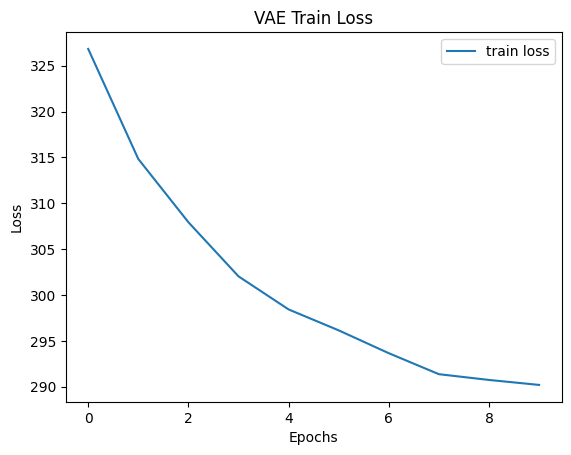

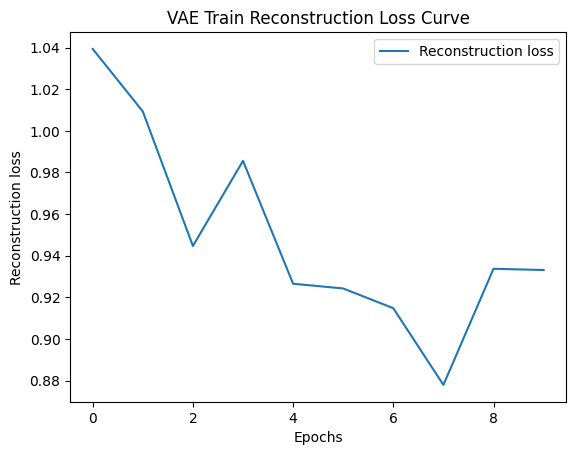

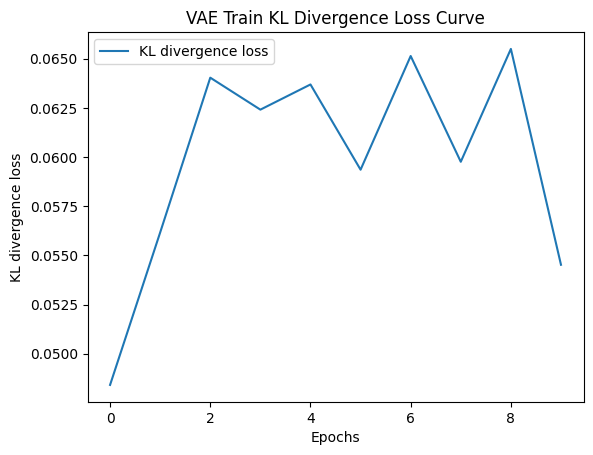

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Z dimension
ZDIM = 5

#Initialize VAE
vae = VAE(ZDIM).to(device)
#Initialize optimizer
optimizer = optim.Adam(vae.parameters(), lr = 1e-3)
#Initialize scheduler(optional)
scheduler = StepLR(optimizer, step_size=10, gamma=0.2)
#num of epochs
num_epochs = 10
import pdb
train_loss_list = []
kl_loss_list = []
bce_loss_list = []

orig_image_list = []
recon_image_list = []
reconst_error = []


# Define Train loop
def train(epochs, train_loader, test_loader):

  for epoch in range(epochs):
      vae.train()
      train_loss = 0
      KL_loss = 0
      bce_loss = 0
      print('Epoch:', epoch,'LR:', scheduler.get_lr())
      for batch_idx, (data, _) in enumerate(train_loader):
          data = data.cuda()
          optimizer.zero_grad()
          recon_batch, mean, log_var = vae(data)

          loss,KL_loss,bce_loss = loss_function(recon_batch, data, mean, log_var)

          loss.backward()
          train_loss += loss.item()
          KL_loss += KL_loss.item()
          bce_loss += bce_loss.item()

          optimizer.step()

          if batch_idx % 100 == 0:
              recon_err = reconstruction_error(vae, test_loader)
              reconst_error.append(recon_err)
              print('Train Epoch: {} {:.0f}% \tLoss: {:.6f} \tRecon_err: {}'.format(epoch+1, 100. * batch_idx / len(train_loader), loss.item() / len(data), recon_err))
          del data; del recon_batch; del mean; del log_var

      train_loss_list.append(train_loss / len(train_loader.dataset))
      kl_loss_list.append(KL_loss / len(train_loader.dataset))
      bce_loss_list.append(bce_loss / len(train_loader.dataset))
      print('Epoch: {} Train loss: {:.4f}'.format(epoch+1, train_loss / len(train_loader.dataset)))
      scheduler.step()

    #   recon_err = reconstruction_error(vae, test_loader)
    #   print('Epoch: {} Reconstruction Error: {:.4f}'.format(epoch+1, recon_err))
      if epoch%5==0:
        with torch.no_grad():

            x_batch =torch.randn(10*10, ZDIM)
            recon_batch = vae.decode(x_batch.to(device))

        orig_image_list.append(vutils.make_grid(x_batch, nrow=10 ,padding=2, normalize=True))
        recon_image_list.append(vutils.make_grid(recon_batch.view(recon_batch.shape[0], 1 , 28, 28).detach().cpu(),nrow=10 , padding=2, normalize=True))

  # save the training checkpoint
  checkpoint = {'vae': vae.state_dict()}
  torch.save(checkpoint, '/content/vae_{}.pt'.format(epochs))
# Run Train loop
train(num_epochs, train_loader, test_loader)

# Plot Train loss
plt.title("VAE Train Loss")
plt.plot(train_loss_list,label="train loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.title("VAE Train Reconstruction Loss Curve")
plt.plot(torch.tensor(bce_loss_list).cpu(),label="Reconstruction loss")
plt.xlabel("Epochs")
plt.ylabel("Reconstruction loss")
plt.legend()
plt.show()

plt.title("VAE Train KL Divergence Loss Curve")
plt.plot(torch.tensor(kl_loss_list).cpu(),label="KL divergence loss")
plt.xlabel("Epochs")
plt.ylabel("KL divergence loss")
plt.legend()
plt.show()






## Qualitative Visualisations

### VAE Testing (TODO)

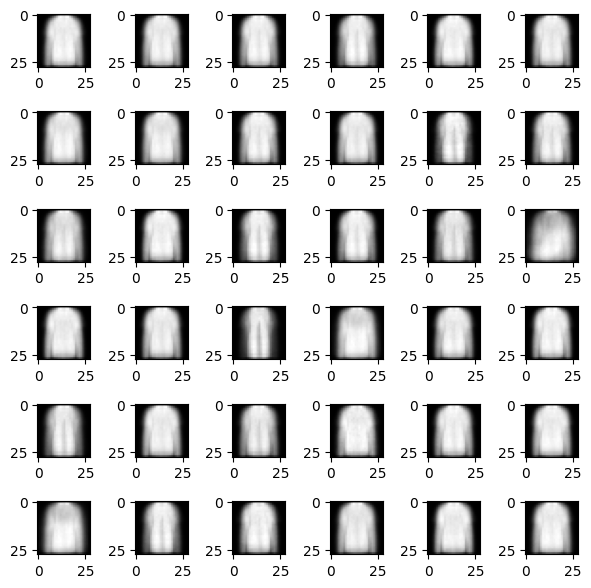

In [ ]:
# Test VAE on a random sample and display on 6X6 grid
grid_size = 6

################################
# Please fill in your code here:

# we want to sample a z from our encoded standard normal distribution. Since encoder's output is n_images, zdim and we are told
#to use grid_size of 6, our z should have shape (grid_size * grid_size, zdim)
vae.eval()
with torch.no_grad():
  z = torch.randn(grid_size*grid_size,ZDIM,device= device)
  output = vae.decode(z)  #(36,784)

#for plotting we need to reshape it to (6,6,28,28)
output = output.cpu().numpy().reshape(grid_size,grid_size, 28,28)
fig,ax = plt.subplots(grid_size,grid_size,figsize = (6,6))
for i in range(grid_size):
  for j in range(grid_size):
    ax[i,j].imshow(output[i,j],cmap = 'gray')

plt.tight_layout()


################################

### Visualize the original vs reconstructed images (TODO)

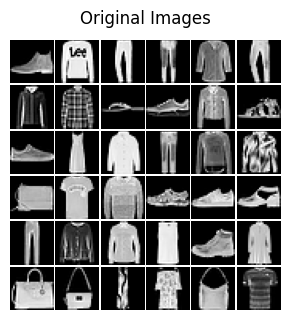

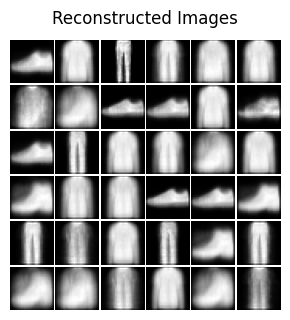

In [ ]:
# Visualise the original vs reconstructed images
# Input the 36 images in Fashion-MNIST to VAE network
# and display reconstructed output on 6X6 grid

################################
# Please fill in your code here:
vae.eval()
with torch.no_grad():
  for batch_idx, (data, _) in enumerate(test_loader):
    #since our batch size was 100, this will have 100 images, we need only 36 images
    data = data.cuda()
    data = data[0:36]  #take first 36 images
    #print(data.shape)
    #torch.Size([36, 1, 28, 28])

    recon_images, mean, log_var = vae.forward(data)
    #since we dont want for every batch, break
    break

#reshape images
recon_images_reshaped = recon_images.view(36, 28, 28).cpu().numpy()
original_images_reshaped = data.view(36, 28, 28).cpu().numpy()


#plot two images grids
fig, ax = plt.subplots(grid_size, grid_size, figsize=(3,3))
for idx, axi in enumerate(ax.flat):
    axi.imshow(original_images_reshaped[idx], cmap='gray')
    axi.axis('off')
plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.suptitle("Original Images", y=1.05)
plt.show()

# Create a subplot for reconstructed images
fig, ax = plt.subplots(grid_size, grid_size, figsize=(3,3))
for idx, axi in enumerate(ax.flat):
    axi.imshow(recon_images_reshaped[idx], cmap='gray')
    axi.axis('off')
plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.suptitle("Reconstructed Images", y=1.05)
plt.show()

################################


## Quantitative Evaluation (TODO)

The Final reconstruction error at end of all epochs is 319.989990234375


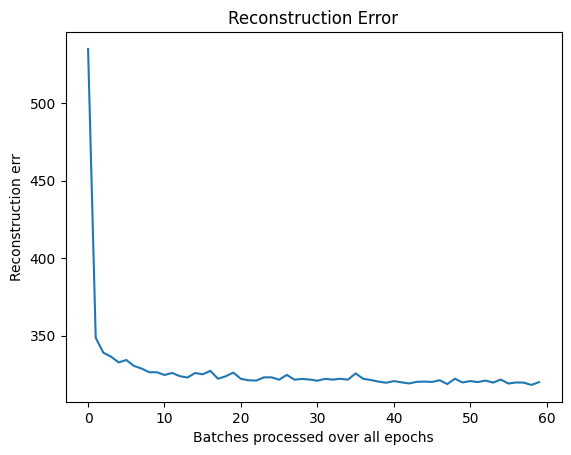

In [ ]:
# Please plot out the reconstruction error curve you saved
# in 'reconstruction_error' list in training.
# And report the final reconstruction error value
################################
# Please fill in your code here:
plt.plot(torch.tensor(reconst_error).cpu())
plt.title("Reconstruction Error")
plt.ylabel("Reconstruction err")
plt.xlabel("Batches processed over all epochs")
################################

#we also need to report the final reconstruction error value
print("The Final reconstruction error at end of all epochs is {}".format(reconst_error[-1]))

### VAE IS score

The following block create 2 torch dataset.

In [ ]:
image.device

device(type='cpu')

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_saved = torch.load('/content/vae_{}.pt'.format(num_epochs))
model_vae = VAE(ZDIM).to(device)
model_vae.load_state_dict(model_saved['vae'])

# Prepare the torch dataset
evaluate_num = 1000
real_set = []
gen_set = []
test_batch_size = 1
test_dataset = datasets.FashionMNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=test_batch_size, shuffle=True)

for idx, data in enumerate(test_loader, 0):
    model_vae.eval()
    image = data[0].to(device)
    # print(image.shape)
    gen_image, _, _ = model_vae(image)

    # print(gen_image.shape)
    gen_image = gen_image.reshape(-1,28,28).unsqueeze(0)
    # print(gen_image.shape)

    image = image.repeat(1,3,1,1)
    gen_image = gen_image.repeat(1,3,1,1)
    real_set.append(image)
    gen_set.append(gen_image)


    if idx == evaluate_num-1:
        break

# make the pytorch dataset
real_set = TensorDataset(torch.cat(real_set))
gen_set = TensorDataset(torch.cat(gen_set))


In [ ]:
real_set.tensors[0].shape

torch.Size([1000, 3, 28, 28])

#### Self-implement IS score (optional TODO)
This optional part is for implementing IS score computation following pdf instructions. You could also use the the next section "IS API" to compute the IS score.
For implementation, you would be asked to implement the most important part "compute_IS" function as an understanding of IS score computation.


In [ ]:
from torchvision.models.inception import inception_v3

def build_feature_table(dataset, model, batch_size, dim, device, upsample):
    '''
    Argms:
    Input:
        dataset: pytorch dataset, you want to evaluate IS score on
        model: Inception network v3
        batch_size: int number
        dim: for IS computation, dim should be 1000 as the final softmax out put dimension
        device: device type torch.device("cuda:0") or torch.device("cpu")
        upsample: Inception network v3 only support input with resolution 299x299
    Output:
        feature_table: (n,dim) numpy matrix
    '''
    # model enter eval mode
    model.eval()
    # initalize the dataloader
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    n = len(dataset)
    idx_counter = 0
    # feature table
    feature_table = np.zeros((n, dim))

    for i, data in tqdm.tqdm(enumerate(dataloader, 0)):
        image = data[0].to(device)
        up = nn.Upsample(size=(299, 299), mode='bilinear')
        with torch.no_grad():
            if upsample == True:
                # upsample to 299x299 resolution
                pred = up(image)
            else:
                pred = image
            pred = model(pred)
            # print(pred.shape)
            pred = F.softmax(pred, dim=1).cpu().numpy()

            feature_table[idx_counter:idx_counter+pred.shape[0]] = pred
            idx_counter += len(pred)
        del image
    assert feature_table.shape == (n, dim)
    return feature_table

def compute_IS(feature_table):
    '''
    Argms:
    Input:
        feature_table: (n,dim) numpy matrix
    Output:
        IS_score: float
    '''
    ################################
    # Please fill in your code here:

    ################################
    return IS_score

def IS(dataset, device, upsample=True, batch_size=64, dim=1000):
    '''
    Argms:
    Input:
        dataset: pytorch dataset, you want to evaluate IS score on
        device: device type torch.device("cuda:0") or torch.device("cpu")
        upsample: Inception network v3 only support input with resolution 299x299
        batch_size: int number
        dim: for IS computation, dim should be 1000 as the final softmax out put dimension
    Output:
        IS_score: float
    '''

    # load InveptionV3 model
    model = inception_v3(pretrained=True, transform_input=False).to(device)

    ## build up the feature table
    feature_table = build_feature_table(dataset, model, batch_size, dim, device, upsample)

    ## IS score computation
    IS_score = compute_IS(feature_table)


    return IS_score



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# compute IS score
real_set_IS_score = IS(real_set, device, upsample = True)
gen_set_IS_score = IS(gen_set, device, upsample = True)
print('real images IS_score:', real_set_IS_score)
print('generated images IS_score:', gen_set_IS_score)

#### IS API
Here you could apply the existed API to compute IS score

In [ ]:
from inception_score import inception_score

import warnings
warnings.filterwarnings("ignore")


print('real images IS_score:')
print(inception_score(real_set, cuda=True, batch_size=64, resize=True, splits=1))

print('generated images IS_score:')
print(inception_score(gen_set, cuda=True, batch_size=64, resize=True, splits=1))

real images IS_score:


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 110MB/s] 


(4.239416295001325, 0.0)
generated images IS_score:
(1.859067807243382, 0.0)


# GAN (please restart you colab session to refresh the GPU memory usage)
### Load data for part 2.1 GAN


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
from torch.optim.lr_scheduler import StepLR
import torchvision.utils as vutils
from torch.utils.data import DataLoader, TensorDataset
from scipy import linalg
from scipy.stats import entropy
import tqdm
import cv2
# Resize image to this size
image_size=64

# Setting up transforms to resize and normalize
transform=transforms.Compose([ transforms.Resize(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# batchsize of dataset
batch_size = 128

# Load STL-10 Dataset
gan_train_dataset = datasets.STL10(root='./stl10_data/', split='train', transform=transform, download=True)
gan_train_loader = torch.utils.data.DataLoader(dataset=gan_train_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 2640397119/2640397119 [02:37<00:00, 16776493.09it/s]


Extracting ./stl10_data/stl10_binary.tar.gz to ./stl10_data/


## Model Definition (TODO)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [101]:
class DCGAN_Generator(nn.Module):
    def __init__(self):
        super(DCGAN_Generator,self).__init__()
        ################################
        # Please fill in your code here:
        self.layer =  nn.Sequential(
            nn.ConvTranspose2d(100, 1024, (4,4),stride = 1, padding = 0, bias = False),
            #it is given in pdf to set bias for convtranspose layers to be False
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.ConvTranspose2d(1024, 512, (4,4),stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256 , (4,4),stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128 , (4,4),stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 3 , (4,4),stride = 2, padding = 1, bias = False),
            nn.Tanh()
        )
        ################################


    def forward(self, input):
        return self.layer(input)


class DCGAN_Discriminator(nn.Module):
    def __init__(self):
        super(DCGAN_Discriminator, self).__init__()
        ################################
        # Please fill in your code here:
        self.layer =  nn.Sequential(
            #input to discriminator is generated image so in_channels = 3
            nn.Conv2d(3, 128, (4,4), stride = 2, padding =1, bias = False),
            nn.LeakyReLU(negative_slope =0.2,inplace=True),

            nn.Conv2d(128, 256, (4,4), stride = 2, padding =1, bias = False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope =0.2,inplace=True),

            nn.Conv2d(256, 512, (4,4), stride = 2, padding =1, bias = False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope =0.2,inplace=True),

            nn.Conv2d(512, 1024, (4,4), stride = 2, padding =1, bias = False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(negative_slope =0.2,inplace=True),

            nn.Conv2d(1024, 1, (4,4), stride = 1, padding =0, bias = False),
            nn.Sigmoid()
        )
        ################################


    def forward(self, input):
        return self.layer(input)

## GAN Training

### GAN loss (TODO)

In [102]:
import torch


fake = torch.load('/content/drive/MyDrive/classwork/cis680/homework/hw5 gans vae/test_case_GAN/test_case_GAN/fake.pt')
netD = torch.load('/content/drive/MyDrive/classwork/cis680/homework/hw5 gans vae/test_case_GAN/test_case_GAN/netD.pt')
real = torch.load('/content/drive/MyDrive/classwork/cis680/homework/hw5 gans vae/test_case_GAN/test_case_GAN/real.pt')
netG = torch.load('/content/drive/MyDrive/classwork/cis680/homework/hw5 gans vae/test_case_GAN/test_case_GAN/netG.pt')
noise = torch.load('/content/drive/MyDrive/classwork/cis680/homework/hw5 gans vae/test_case_GAN/test_case_GAN/noise.pt')
Valid_label = torch.load('/content/drive/MyDrive/classwork/cis680/homework/hw5 gans vae/test_case_GAN/test_case_GAN/Valid_label.pt')
Fake_label = torch.load('/content/drive/MyDrive/classwork/cis680/homework/hw5 gans vae/test_case_GAN/test_case_GAN/Fake_label.pt')
criterion = torch.load('/content/drive/MyDrive/classwork/cis680/homework/hw5 gans vae/test_case_GAN/test_case_GAN/criterion.pt')

"""
fake = torch.load('test_case_GAN/fake.pt')
netD = torch.load('test_case_GAN/netD.pt')
real = torch.load('test_case_GAN/real.pt')
netG = torch.load('test_case_GAN/netG.pt')
noise = torch.load('test_case_GAN/noise.pt')
Valid_label = torch.load('test_case_GAN/Valid_label.pt')
Fake_label = torch.load('test_case_GAN/Fake_label.pt')
criterion = torch.load('test_case_GAN/criterion.pt')
"""




def loss_discriminator(D, real, G, noise, Valid_label, Fake_label, criterion):
    '''
    1. Forward real images into the discriminator
    2. Compute loss between Valid_label and dicriminator output on real images
    3. Forward noise into the generator to get fake images
    4. Forward fake images to the discriminator
    5. Compute loss between Fake_label and discriminator output on fake images
    6. sum real loss and fake loss as the loss_D
    7. we also need to output fake images generate by G(noise) for loss_generator computation
    '''
    #real -> real image
    output = D.forward(real)
    # BCE Loss bw real image, valid label (set of 1s)
    loss_on_real_image = criterion(output.view(-1),Valid_label)

    #for generator loss, forward noise -> pass fake image to discriminator-> BCE Loss bw fake image and fake label
    fake_image = G.forward(noise)

    # I use detach below because if i dont do so, both discriminator and generator will use same computation graph & backpropag will not happen for 2nd time.
    # I was getting error. This solves it
    output = D.forward(fake_image.detach())
    loss_on_fake_image = criterion(output.view(-1), Fake_label)
    #
    #max(  E[nn.BCELoss(D(x),1)] + E[nn.BCELoss(D(G(z)),0)]   )

    loss_D = loss_on_real_image + loss_on_fake_image
    # return total loss_D and fake images
    fake = fake_image
    return loss_D, fake


def loss_generator(netD, fake, Valid_label, criterion):
    '''
    1. Forward fake images to the discriminator
    2. Compute loss between valid labels and discriminator output on fake images
    '''
    #netD -> discriminator object
    output = netD.forward(fake)
    loss_G = criterion( output.view(-1), Valid_label)

    #return loss_G
    return loss_G


loss_D, fake_G = loss_discriminator(netD, real, netG, noise, Valid_label, Fake_label, criterion)
#torch.save(loss_D, 'test_case_GAN/loss_D.pt')
#torch.save(loss_D, '/content/drive/MyDrive/classwork/cis680/homework/hw5 gans vae/test_case_GAN/test_case_GAN/loss_D.pt')

loss_G = loss_generator(netD, fake, Valid_label, criterion)
#torch.save(loss_G, 'test_case_GAN/loss_G.pt')
#torch.save(loss_G, '/content/drive/MyDrive/classwork/cis680/homework/hw5 gans vae/test_case_GAN/test_case_GAN/loss_G.pt')


#test_loss_D = torch.load('test_case_GAN/loss_D.pt')
#test_loss_G = torch.load('test_case_GAN/loss_G.pt')
test_loss_D = torch.load('/content/drive/MyDrive/classwork/cis680/homework/hw5 gans vae/test_case_GAN/test_case_GAN/loss_D.pt')
test_loss_G = torch.load('/content/drive/MyDrive/classwork/cis680/homework/hw5 gans vae/test_case_GAN/test_case_GAN/loss_G.pt')


print('test case loss_D:', test_loss_D.item())
print('computed loss_D:', loss_D.item())

print('test case loss_G:', test_loss_G.item())
print('computed loss_G:', loss_G.item())


test case loss_D: 1.3626351356506348
computed loss_D: 1.3626351356506348
test case loss_G: 0.7321602702140808
computed loss_G: 0.7321602702140808


### Training block

In [ ]:
# create directory to store model checkpoints
import os
os.mkdir('/content/drive/MyDrive/classwork/cis680/homework/hw5 gans vae/GAN_checkpoints/')

[0/100][0/40]	Loss_D: 1.3842	Loss_G: 0.8250	
[1/100][0/40]	Loss_D: 0.0615	Loss_G: 3.9339	
[2/100][0/40]	Loss_D: 0.1271	Loss_G: 4.5124	
[3/100][0/40]	Loss_D: 0.0564	Loss_G: 5.7147	
[4/100][0/40]	Loss_D: 0.1096	Loss_G: 7.1077	
[5/100][0/40]	Loss_D: 0.4971	Loss_G: 7.0759	
[6/100][0/40]	Loss_D: 0.1767	Loss_G: 5.1600	
[7/100][0/40]	Loss_D: 0.4386	Loss_G: 4.9181	
[8/100][0/40]	Loss_D: 1.1802	Loss_G: 4.2319	
[9/100][0/40]	Loss_D: 0.6088	Loss_G: 1.3776	
[10/100][0/40]	Loss_D: 0.2940	Loss_G: 4.4157	
[11/100][0/40]	Loss_D: 1.0527	Loss_G: 2.3547	
[12/100][0/40]	Loss_D: 0.9335	Loss_G: 2.3038	
[13/100][0/40]	Loss_D: 0.5122	Loss_G: 3.3460	
[14/100][0/40]	Loss_D: 0.4563	Loss_G: 4.7625	
[15/100][0/40]	Loss_D: 0.4516	Loss_G: 3.9406	
[16/100][0/40]	Loss_D: 0.6395	Loss_G: 3.3031	
[17/100][0/40]	Loss_D: 0.3461	Loss_G: 2.4749	
[18/100][0/40]	Loss_D: 1.0016	Loss_G: 4.8999	
[19/100][0/40]	Loss_D: 1.3446	Loss_G: 6.5360	
[20/100][0/40]	Loss_D: 0.9761	Loss_G: 5.2113	
[21/100][0/40]	Loss_D: 0.3843	Loss_G: 3.5710

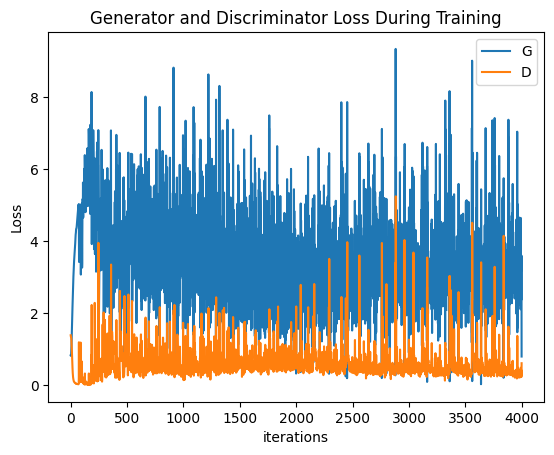

CPU times: user 39min 20s, sys: 3.6 s, total: 39min 24s
Wall time: 39min 38s


In [103]:
%%time
import torchvision.utils as vutils
from torch.optim.lr_scheduler import StepLR
import pdb

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Number of channels
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 128
# Size of feature maps in discriminator
ndf = 128


# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Create the generator and discriminator
netG = DCGAN_Generator().to(device)
netD = DCGAN_Discriminator().to(device)

# Apply weight initialization
netG.apply(weights_init)
netD.apply(weights_init)


# Initialize BCELoss function
criterion = nn.BCELoss()

# Create latent vector to test the generator performance
fixed_noise = torch.randn(36, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

learning_rate = 0.0002
beta1 = 0.5

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=learning_rate, betas=(beta1, 0.999))

img_list = []
real_img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 100


def load_param(num_eps):
  #model_saved = torch.load('/content/gan_{}.pt'.format(num_eps))
  model_saved = torch.load('/content/drive/MyDrive/classwork/cis680/homework/hw5 gans vae/GAN_checkpoints/gan_{}.pt'.format(num_eps))
  netG.load_state_dict(model_saved['netG'])
  netD.load_state_dict(model_saved['netD'])

# GAN Training Loop
for epoch in range(num_epochs):
    for i, data in enumerate(gan_train_loader, 0):
        real = data[0].to(device)
        b_size = real.size(0)
        noise = torch.randn(b_size, nz, 1, 1, device=device)

        Valid_label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        Fake_label = torch.full((b_size,), fake_label, dtype=torch.float, device=device)
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        netD.zero_grad()
        # Function to compute discriminator loss
        loss_D, fake = loss_discriminator(netD, real, netG, noise, Valid_label, Fake_label, criterion)


        # torch.save(fake,'test_case_GAN/fake.pt')
        # torch.save(netD,'test_case_GAN/netD.pt')
        # torch.save(real,'test_case_GAN/real.pt')
        # torch.save(netG,'test_case_GAN/netG.pt')
        # torch.save(noise,'test_case_GAN/noise.pt')
        # torch.save(Valid_label,'test_case_GAN/Valid_label.pt')
        # torch.save(Fake_label,'test_case_GAN/Fake_label.pt')
        # torch.save(criterion,'test_case_GAN/criterion.pt')

        # pdb.set_trace()

        loss_D.backward()
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        # Function to compute generator loss
        loss_G = loss_generator(netD, fake, Valid_label, criterion)
        # Calculate gradients for G
        loss_G.backward()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\t'
                  % (epoch, num_epochs, i, len(gan_train_loader),
                     loss_D.item(), loss_G.item()))
            # Save Losses for plotting later
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())



        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(gan_train_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

    # we also need to add the part where we are saving checkpoints every 10 epochs since we need to visualize it later in
    #qualitative section. We will do this after end of epoch

    if epoch%10==0:
      checkpoint = {'netG': netG.state_dict(),'netD': netD.state_dict()}
      torch.save(checkpoint, '/content/drive/MyDrive/classwork/cis680/homework/hw5 gans vae/GAN_checkpoints/gan_{}.pt'.format(epoch))




plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

#we will save checkpoints locally in drive
checkpoint = {'netG': netG.state_dict(),
              'netD': netD.state_dict()}
#torch.save(checkpoint, '/content/gan_{}.pt'.format(num_epochs))
torch.save(checkpoint, '/content/drive/MyDrive/classwork/cis680/homework/hw5 gans vae/GAN_checkpoints/gan_ {}.pt'.format(num_epochs))


## Qualitative Visualisations

### GAN Testing (TODO)

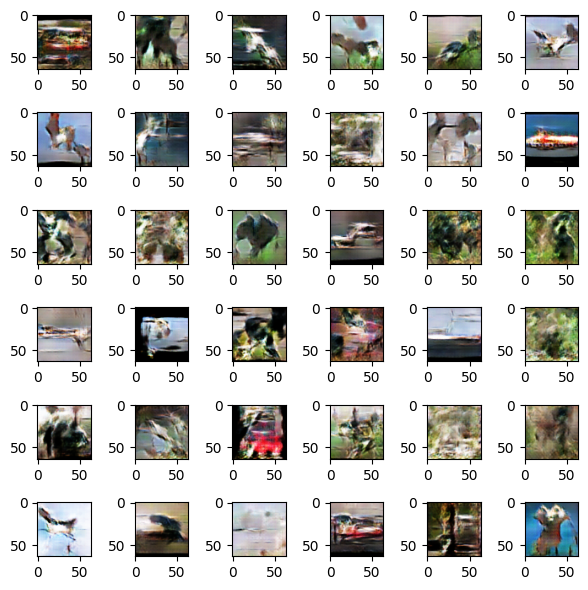

In [104]:
# Test GAN on a random sample and display on 6X6 grid

################################
# Please fill in your code here:
grid_size = 6
checkpoint = torch.load(f'/content/drive/MyDrive/classwork/cis680/homework/hw5 gans vae/GAN_checkpoints/gan_ 100.pt')
#next we load weights from checkpoint file
netG.load_state_dict(checkpoint['netG'])

#we have netG(best generator model) object. we just need to pass 36 images to this and plot the resultant fake images on a grid
with torch.no_grad():
  gaussian_noise = torch.randn(36, nz, 1, 1, device=device)
  fake_images = netG.forward(gaussian_noise)

#fake_images have shape torch.Size([36, 3, 64, 64]) -> we need to change it to [36,64,64,3] for plotting

output = fake_images.cpu().numpy().transpose(0,2,3,1)
fig,ax = plt.subplots(grid_size,grid_size,figsize = (6,6))
for i in range(grid_size):
  for j in range(grid_size):
    img = output[i * grid_size + j]
    img = (img - img.min()) / (img.max() - img.min())
    ax[i,j].imshow(img,cmap = 'gray')

plt.tight_layout()

################################


In [ ]:
fake_images.shape

torch.Size([36, 3, 64, 64])

### Visualisation at different epochs (TODO)

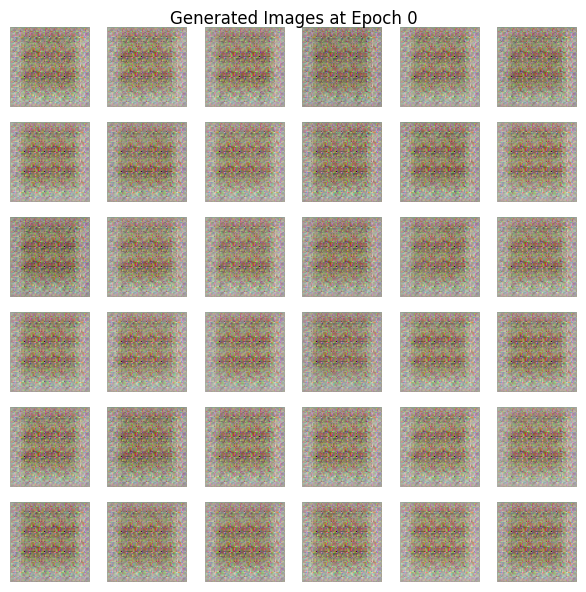

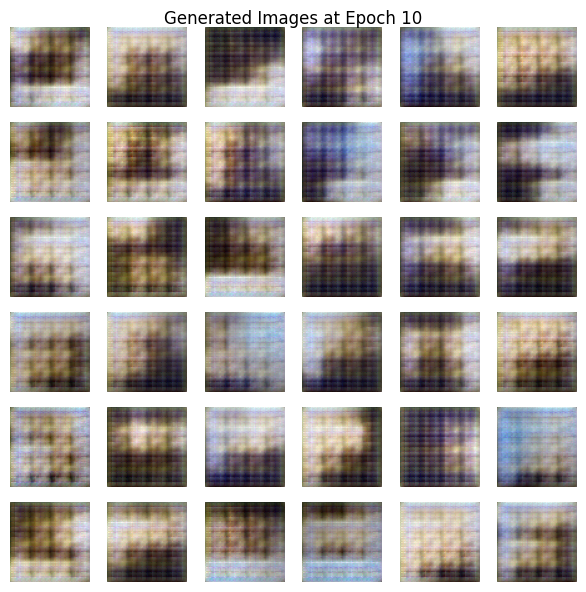

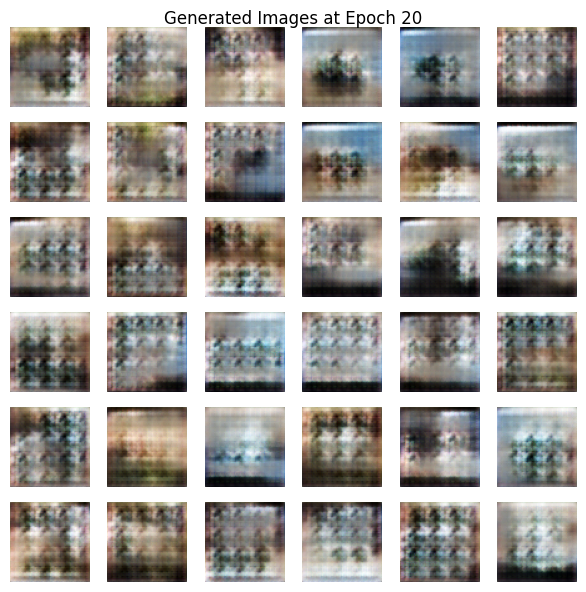

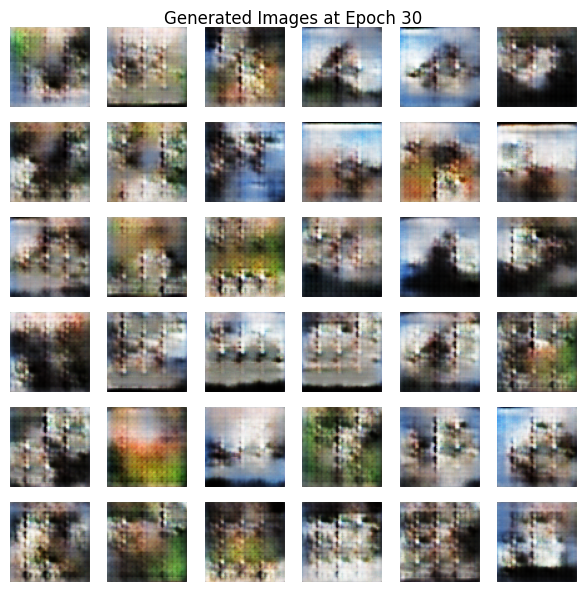

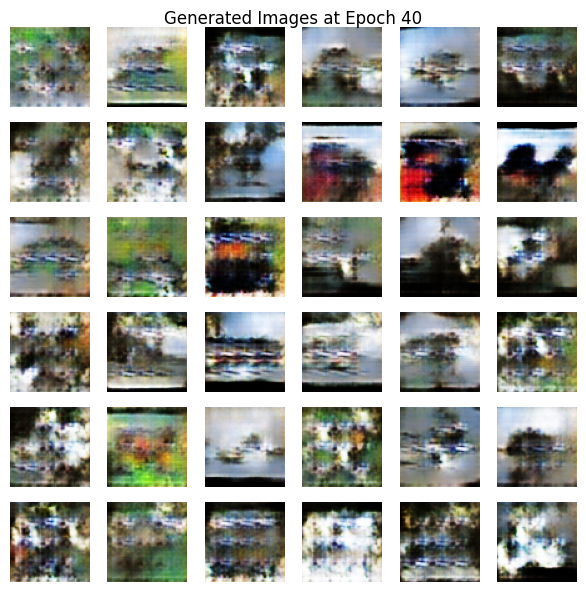

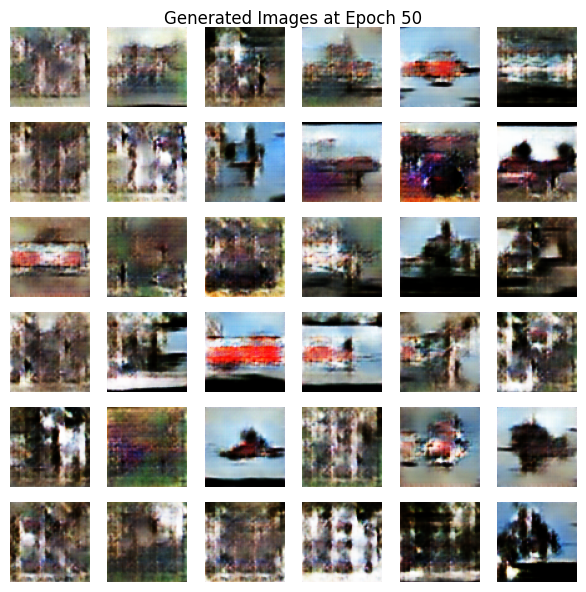

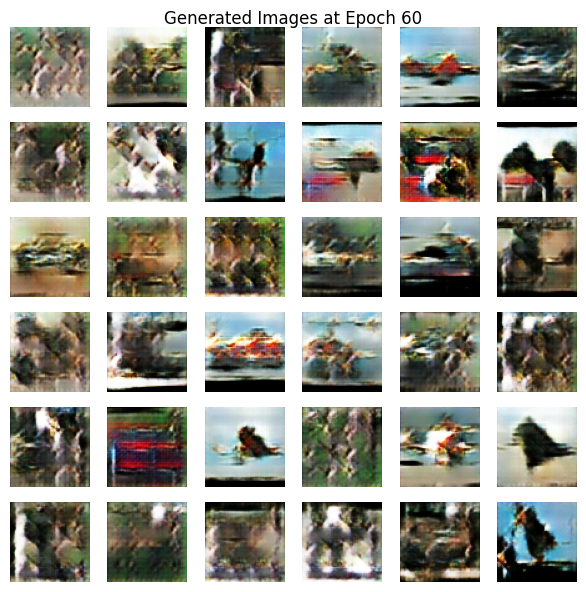

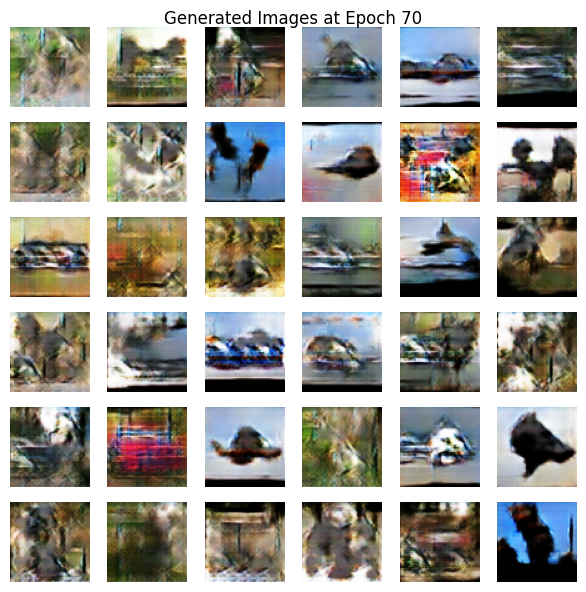

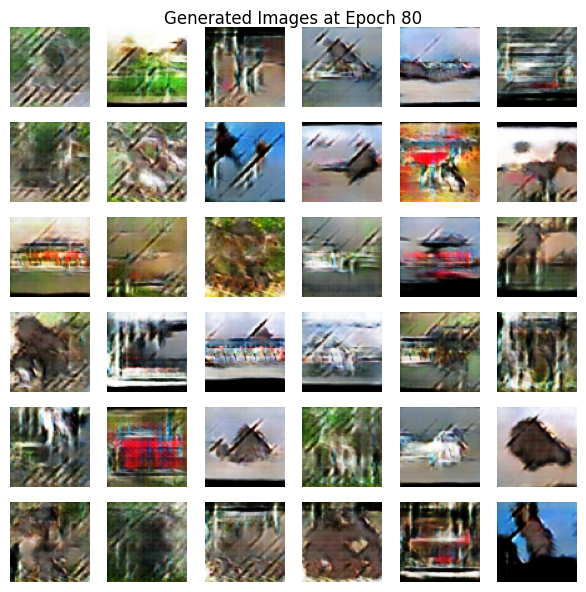

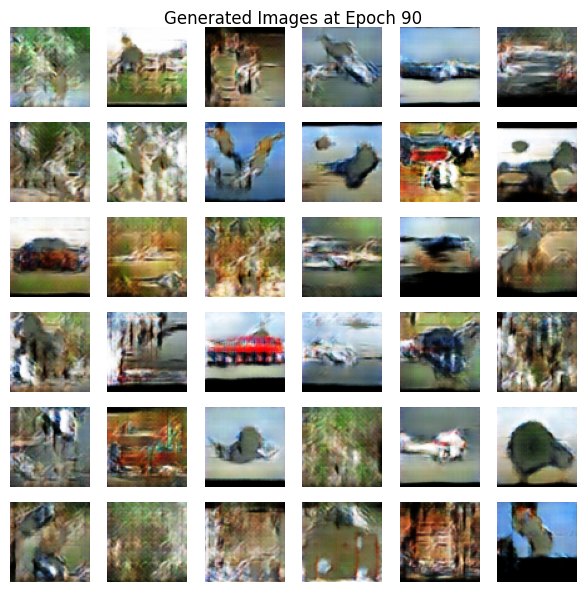

In [105]:
# Plot GAN generated images at different epochs during training
################################
# Please fill in your code here:
with torch.no_grad():
  gaussian_noise = torch.randn(36, nz, 1, 1, device=device)
  ## In our training block, we are saving model. We just need to load them every 10 epochs as told in pdf
  for i in range (0,10):
    checkpoint = torch.load(f'/content/drive/MyDrive/classwork/cis680/homework/hw5 gans vae/GAN_checkpoints/gan_{i*10}.pt')
    #next we load weights from checkpoint file

    netG.load_state_dict(checkpoint['netG'])

    fake_images = netG.forward(gaussian_noise)
    output = fake_images.cpu().numpy().transpose(0,2,3,1)

    fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(6, 6))
    for ax_idx, ax in enumerate(axes.flat):
        img = output[ax_idx]
        # Normalize the image to [0, 1] range
        img = (img - img.min()) / (img.max() - img.min())

        # Display image
        ax.imshow(img)
        ax.axis('off')  # Turn off axis

    plt.suptitle(f"Generated Images at Epoch {i*10}")
    plt.savefig('/content/drive/MyDrive/classwork/cis680/homework/hw5 gans vae/results/v2/Image_at_epoch_{}.png'.format(i*10))
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)


################################


## Quantitative Evaluation

In [106]:
# Resize image to this size
image_size=64

# Setting up transforms to resize and normalize
transform=transforms.Compose([ transforms.Resize(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Load STL-10 test set
test_batch_size = 1
gan_test_dataset = datasets.STL10(root='./stl10_data/', split='test', transform=transform, download=True)
gan_test_loader = torch.utils.data.DataLoader(dataset=gan_test_dataset, batch_size=test_batch_size, shuffle=False)

Files already downloaded and verified


### FID score for GAN
This part, you would be asked to compute a FID score between the real image and the generated images to evaluate the photo-realistic quality of the generated images.
For this part, we should create three folder:
- 1. STL_10_real_1
- 2. STL_10_real_2
- 3. STL_10_fake


In [107]:
! mkdir STL_10_fake STL_10_real_1 STL_10_real_2

mkdir: cannot create directory ‘STL_10_fake’: File exists
mkdir: cannot create directory ‘STL_10_real_1’: File exists
mkdir: cannot create directory ‘STL_10_real_2’: File exists


Create the dataset to evaluate quantitative scores.

In [113]:
num_epochs

100

In [108]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Number of channels
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 128
# Size of feature maps in discriminator
ndf = 128
# Load checkpoint
model_saved = torch.load('/content/gan_{}.pt'.format(num_epochs))
netG = DCGAN_Generator()
netG.load_state_dict(model_saved['netG'])
netG.to(device)


def denorm(x, norm_mean, norm_std):
    y = torch.zeros(x.shape)
    y[:,0,:,:] = x[:,0,:,:]*norm_std[0] + norm_mean[0]
    y[:,1,:,:] = x[:,1,:,:]*norm_std[1] + norm_mean[1]
    y[:,2,:,:] = x[:,2,:,:]*norm_std[2] + norm_mean[2]
    return y



evaluate_num = 1000

# make the gen data set and folder
gen_set = []
for idx in range(evaluate_num):
    with torch.no_grad():
        fixed_noise = torch.randn(1, nz, 1, 1, device=device)
        fake = netG(fixed_noise).detach().cpu()
        fake = fake.cpu().detach()
        fake_denorm = denorm(fake, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        # print(fake_denorm.shape)
        gen_set.append(fake_denorm)

        # plt.imshow(np.transpose(vutils.make_grid(fake, nrow=6 ,padding=2, normalize=True),(1,2,0)), animated=True)
        save_image(fake.squeeze(), './STL_10_fake/fake' + str(idx) + '.png', normalize=True)

gen_dataset = TensorDataset(torch.cat(gen_set))

# make the real data set and folder
real_set_1 = []
real_set_2 = []

for idx, data in enumerate(gan_test_loader, 0):
    image = data[0]
    # print(image.shape)
    image_denorm = denorm(image, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    if idx < evaluate_num:
        real_set_1.append(image_denorm)
        save_image(image.squeeze(), './STL_10_real_1/real' + str(idx) + '.png', normalize=True)
    elif evaluate_num <= idx < 2*evaluate_num:
        real_set_2.append(image_denorm)
        save_image(image.squeeze(), './STL_10_real_2/real' + str(idx) + '.png', normalize=True)
    if idx == 2*evaluate_num-1:
        break

# make the pytorch dataset
real_dataset_1 = TensorDataset(torch.cat(real_set_1))
real_dataset_2 = TensorDataset(torch.cat(real_set_2))


#### Self-implement FID score (optional TODO)
This optional part is for implementing FID score computation following pdf instructions. Implement "compute_FID" function which is the most important part in FID score computation. You could also use the the next section "FID API" to compute the FID score.

In [ ]:
! pip install pytorch-fid
from pytorch_fid.inception import InceptionV3

def build_feature_table(dataset, model, batch_size, dim, device):
    '''
    Argms:
    Input:
        dataset: pytorch dataset, you want to evaluate IS score on
        model: Inception network v3
        batch_size: int number
        dim: for IS computation, dim should be 1000 as the final softmax out put dimension
        device: device type torch.device("cuda:0") or torch.device("cpu")
    Output:
        feature_table: (n,dim) numpy matrix
    '''
    # model enter eval mode
    model.eval()
    # initalize the dataloader
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    n = len(dataset)
    idx_counter = 0
    # feature table
    feature_table = np.zeros((n, dim))

    for i, data in tqdm.tqdm(enumerate(dataloader, 0)):
        image = data[0].to(device)

        with torch.no_grad():
            pred = model(image)[0]
            pred = pred.squeeze(3).squeeze(2).cpu().numpy()
            feature_table[idx_counter:idx_counter+pred.shape[0]] = pred
            idx_counter += len(pred)

    return feature_table

def compute_stat(feature_table):
    '''
    Argms:
    Input:
        feature_table: (n,dim) numpy matrix
    Output:
        mu: mean along row dimension
        sigma: covarance matrix of dataset
    '''
    # compute mean and sigma based on activation table
    mu = np.mean(feature_table, axis=0)
    sigma = np.cov(feature_table, rowvar=False)

    # print('dimension of mu', mu.shape)
    # print('dimension of sigma', sigma.shape)
    return mu, sigma


def compute_FID(mu_1, sigma_1, mu_2, sigma_2, eps=1e-6):
    '''
    Argms:
    Input:
        mu_1: mean vector we get for dataset1
        sigma_1: covariance matrix for dataset1
        mu_2: mean vector we get for dataset2
        sigma_2: covariance matrix for dataset1
    Output:
        FID score: float
    '''

    # compute mu difference

    # compute square root of Sigma1*Sigma2 using "linalg.sqrtm" from scipy
    # please name the resulting matrix as covmean

    # The following block take care of imagionary part of covmean
    #################################################################
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma_1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma_1 + offset).dot(sigma_2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real
    #################################################################

    # compute FID score, based on eqution.(10) in pdf FID part.


    return FID_score

def FID(dataset_1, dataset_2, device, batch_size=64, dim=2048, block_idx = 3):
    '''
    Argms:
    Input:
        dataset_1: pytorch dataset
        dataset_2: pytorch dataset
        device: device type torch.device("cuda:0") or torch.device("cpu")
        batch_size: int number
        dim: for IS computation, dim should be 1000 as the final softmax out put dimension
        block_idx: the block stage index we want to use in inception module
    Output:
        FID_score: float
    '''
    # load InveptionV3 model
    model = InceptionV3([block_idx]).to(device)

    ## build up the feature table
    feature_table_1 = build_feature_table(dataset_1, model, batch_size, dim, device)
    feature_table_2 = build_feature_table(dataset_2, model, batch_size, dim, device)


    ## compute mu, sigma for dataset 1&2
    mu_1, sigma_1 = compute_stat(feature_table_1)
    mu_2, sigma_2 = compute_stat(feature_table_2)


    ## FID score computation
    FID_score = compute_FID(mu_1, sigma_1, mu_2, sigma_2, eps=1e-6)


    return FID_score


In [109]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# compute FID using FID function you implemented above
FID_score = FID(real_dataset_1, real_dataset_1, device)
print('FID_score between real_dataset_1 and itself:', FID_score)

FID_score = FID(real_dataset_1, real_dataset_2, device)
print('FID_score between real_dataset_1 and real_dataset_2:', FID_score)

FID_score = FID(real_dataset_1, gen_dataset, device)
print('FID_score between real_dataset_1 and generated image set:', FID_score)

NameError: ignored

#### FID API

In [110]:
! pip install pytorch-fid
! python -m pytorch_fid '/content/STL_10_real_1' '/content/STL_10_real_1' --gpu 0
! python -m pytorch_fid '/content/STL_10_real_1' '/content/STL_10_real_2' --gpu 0
! python -m pytorch_fid '/content/STL_10_real_1' '/content/STL_10_fake' --gpu 0


usage: __main__.py [-h] [--batch-size BATCH_SIZE] [--num-workers NUM_WORKERS] [--device DEVICE]
                   [--dims {64,192,768,2048}] [--save-stats]
                   path path
__main__.py: error: unrecognized arguments: --gpu 0
usage: __main__.py [-h] [--batch-size BATCH_SIZE] [--num-workers NUM_WORKERS] [--device DEVICE]
                   [--dims {64,192,768,2048}] [--save-stats]
                   path path
__main__.py: error: unrecognized arguments: --gpu 0
usage: __main__.py [-h] [--batch-size BATCH_SIZE] [--num-workers NUM_WORKERS] [--device DEVICE]
                   [--dims {64,192,768,2048}] [--save-stats]
                   path path
__main__.py: error: unrecognized arguments: --gpu 0


If you implement the self-implement FID version. You would notice a negligible difference in value. Because the API package compute this value by saving and reading tensor from .png files. Accuracy problem could happen in the middle of transation.

### IS score for GAN

#### Self-implement IS score (optional)

You could copy and paste this function from VAE part if you have implement that part.


In [111]:
from torchvision.models.inception import inception_v3

def build_feature_table(dataset, model, batch_size, dim, device, upsample):
    '''
    Argms:
    Input:
        dataset: pytorch dataset, you want to evaluate IS score on
        model: Inception network v3
        batch_size: int number
        dim: for IS computation, dim should be 1000 as the final softmax out put dimension
        device: device type torch.device("cuda:0") or torch.device("cpu")
        upsample: Inception network v3 only support input with resolution 299x299
    Output:
        feature_table: (n,dim) numpy matrix
    '''
    # model enter eval mode
    model.eval()
    # initalize the dataloader
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    n = len(dataset)
    idx_counter = 0
    # feature table
    feature_table = np.zeros((n, dim))

    for i, data in tqdm.tqdm(enumerate(dataloader, 0)):
        image = data[0].to(device)
        up = nn.Upsample(size=(299, 299), mode='bilinear')
        with torch.no_grad():
            if upsample == True:
                # upsample to 299x299 resolution
                pred = up(image)
            pred = model(pred)
            # print(pred.shape)
            pred = F.softmax(pred, dim=1).cpu().numpy()

            feature_table[idx_counter:idx_counter+pred.shape[0]] = pred
            idx_counter += len(pred)
    assert feature_table.shape == (n, dim)
    return feature_table

def compute_IS(feature_table):
    '''
    Argms:
    Input:
        feature_table: (n,dim) numpy matrix
    Output:
        IS_score: float
    '''
    ################################
    # Please fill in your code here:

    ################################
    return IS_score

def IS(dataset, device, upsample=True, batch_size=64, dim=1000):
    '''
    Argms:
    Input:
        dataset: pytorch dataset, you want to evaluate IS score on
        device: device type torch.device("cuda:0") or torch.device("cpu")
        upsample: Inception network v3 only support input with resolution 299x299
        batch_size: int number
        dim: for IS computation, dim should be 1000 as the final softmax out put dimension
    Output:
        IS_score: float
    '''

    # load InveptionV3 model
    model = inception_v3(pretrained=True, transform_input=False).to(device)

    ## build up the feature table
    feature_table = build_feature_table(dataset, model, batch_size, dim, device, upsample)

    ## IS score computation
    IS_score = compute_IS(feature_table)


    return IS_score



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# compute IS score
real_set_IS_score = IS(real_dataset_1, device, upsample = True)
gen_set_IS_score = IS(gen_dataset, device, upsample = True)
print('real images IS_score:', real_set_IS_score)
print('generated images IS_score:', gen_set_IS_score)

#### IS API

In [112]:
from inception_score import inception_score
import warnings
warnings.filterwarnings("ignore")

print('IS score for real data set 1:')
print(inception_score(real_dataset_1, cuda=True, batch_size=64, resize=True, splits=1))
print('IS score for generated data set:')
print(inception_score(gen_dataset, cuda=True, batch_size=64, resize=True, splits=1))

IS score for real data set 1:
(14.623364188788035, 0.0)
IS score for generated data set:
(1.00014157166349, 0.0)
